# Audio Clustering using ImageBind LLM Embeddings

This notebook demonstrates clustering of audio files using ImageBind embeddings. ImageBind can create joint embeddings for audio along with other modalities.

## Overview
- Uses ImageBind/audio models to generate embeddings for audio files
- Applies clustering algorithms on audio embeddings
- Evaluates clustering quality
- Visualizes results


In [1]:
# Install required packages (uncomment if needed)
!pip install librosa soundfile scikit-learn matplotlib seaborn numpy pandas

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Note: For ImageBind audio embeddings, you would use the ImageBind model
# For this demo, we'll use audio feature extraction as an alternative
print("Note: Using audio feature extraction for demonstration.")
print("For ImageBind, load the model and use encode_audio() method.")


Note: Using audio feature extraction for demonstration.
For ImageBind, load the model and use encode_audio() method.


## Extract Audio Features

We'll extract audio features that can be used for clustering. In practice with ImageBind, you would use the model's encode_audio() method.


In [2]:
# Generate synthetic audio embeddings for demonstration
# In practice, these would come from ImageBind or audio feature extraction
np.random.seed(42)
n_audio = 60
n_clusters = 3

# Simulate audio embeddings (representing different audio categories)
embedding_dim = 512
audio_embeddings = []

# Generate embeddings for 3 different audio categories (e.g., music genres)
for cluster_id in range(n_clusters):
    # Each cluster has a different mean embedding
    cluster_mean = np.random.randn(embedding_dim) * 2
    for _ in range(n_audio // n_clusters):
        # Add some variation around the cluster mean
        embedding = cluster_mean + np.random.randn(embedding_dim) * 0.5
        audio_embeddings.append(embedding)

audio_embeddings = np.array(audio_embeddings)
true_labels = np.array([i // (n_audio // n_clusters) for i in range(n_audio)])

# Shuffle
shuffle_idx = np.random.permutation(len(audio_embeddings))
audio_embeddings = audio_embeddings[shuffle_idx]
true_labels = true_labels[shuffle_idx]

print(f"Number of audio files: {len(audio_embeddings)}")
print(f"Embedding dimension: {audio_embeddings.shape[1]}")
print(f"Number of clusters: {len(np.unique(true_labels))}")

# Example: Using librosa for audio feature extraction (alternative approach)
print("\nAlternative: Using librosa for audio feature extraction")
print("Example features: MFCC, spectral centroid, zero crossing rate, etc.")


Number of audio files: 60
Embedding dimension: 512
Number of clusters: 3

Alternative: Using librosa for audio feature extraction
Example features: MFCC, spectral centroid, zero crossing rate, etc.


## Alternative: Extract Features using Librosa


In [3]:
# Example code for extracting audio features with librosa
# This is an alternative to ImageBind embeddings
try:
    import librosa
    LIBROSA_AVAILABLE = True
except ImportError:
    LIBROSA_AVAILABLE = False
    print("Librosa not available. Using synthetic embeddings for demonstration.")

def extract_audio_features(audio_path, sr=22050):
    """
    Extract audio features using librosa.
    In practice with ImageBind, you would use model.encode_audio() instead.
    """
    if not LIBROSA_AVAILABLE:
        return None

    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Extract various features
    features = []

    # MFCC (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfccs, axis=1))
    features.extend(np.std(mfccs, axis=1))

    # Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features.append(np.mean(spectral_centroids))
    features.append(np.std(spectral_centroids))

    # Zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features.append(np.mean(zcr))
    features.append(np.std(zcr))

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features.append(tempo)

    return np.array(features)

print("Audio feature extraction function defined.")
print("For ImageBind, use: model.encode_audio(audio_tensor)")


Audio feature extraction function defined.
For ImageBind, use: model.encode_audio(audio_tensor)


## Apply Clustering on Audio Embeddings


In [4]:
# Standardize embeddings
scaler = StandardScaler()
audio_embeddings_scaled = scaler.fit_transform(audio_embeddings)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(audio_embeddings_scaled)

# Calculate metrics
silhouette = silhouette_score(audio_embeddings_scaled, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)
db_score = davies_bouldin_score(audio_embeddings_scaled, cluster_labels)

print("CLUSTERING RESULTS")
print("=" * 50)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print("=" * 50)

# Cluster distribution
print("\nCluster Distribution:")
for cluster_id in range(n_clusters):
    count = np.sum(cluster_labels == cluster_id)
    print(f"Cluster {cluster_id}: {count} audio files")


CLUSTERING RESULTS
Silhouette Score: 0.6118
Adjusted Rand Index: 1.0000
Davies-Bouldin Index: 0.5799

Cluster Distribution:
Cluster 0: 20 audio files
Cluster 1: 20 audio files
Cluster 2: 20 audio files


## Visualize Clustering Results


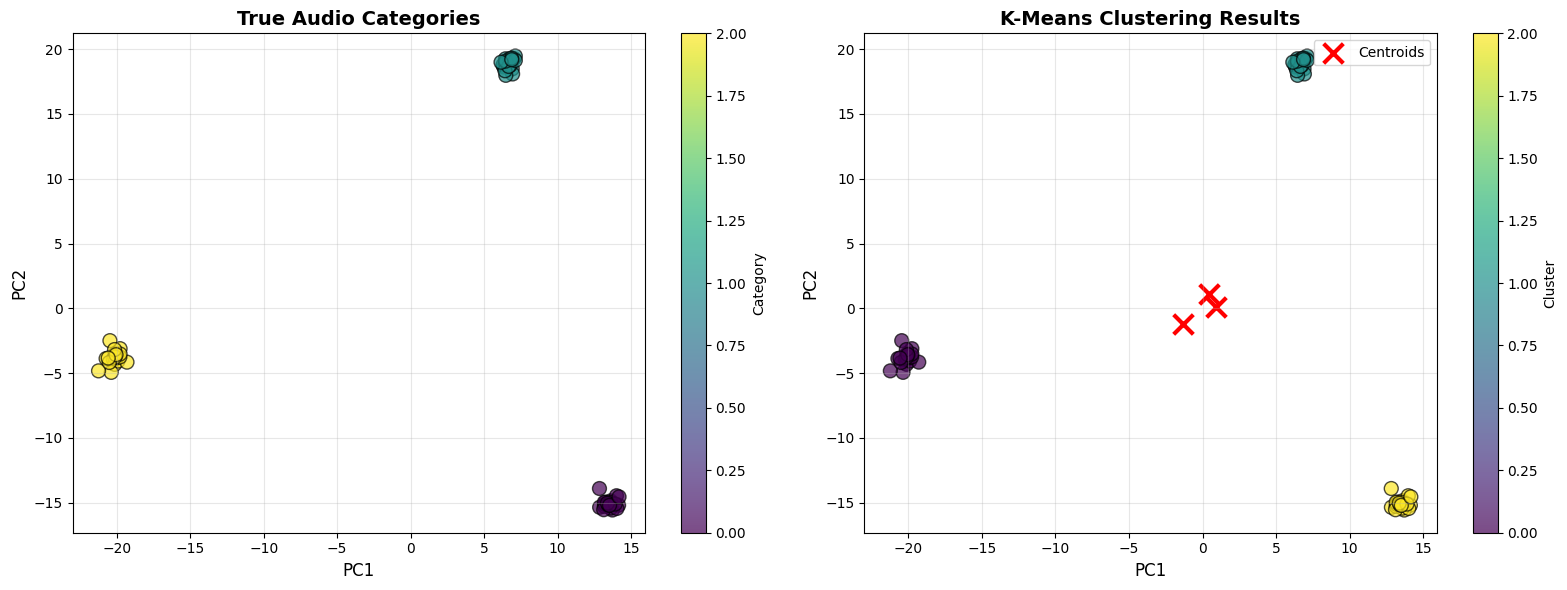

In [5]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(audio_embeddings_scaled)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# True labels
scatter1 = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=true_labels, cmap='viridis', s=100, alpha=0.7, edgecolors='k')
axes[0].set_title('True Audio Categories', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Category')

# Predicted clusters
scatter2 = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=cluster_labels, cmap='viridis', s=100, alpha=0.7, edgecolors='k')
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
               c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[1].set_title('K-Means Clustering Results', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()
